In [1]:
# pip install scikit-learn matplotlib scipy

import warnings
warnings.filterwarnings('ignore')

import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.neighbors import KernelDensity

plt.style.use('seaborn-v0_8-whitegrid')
np.random.seed(42)

# 1. Kernel Density Estimation (KDE)

**Idea**: Place a "bump" (kernel) centered at each observation and average them.

$$\hat{p}(x) = \frac{1}{nh} \sum_{i=1}^n K\left(\frac{x - x_i}{h}\right)$$

where:
- $K(\cdot)$ is a **kernel function** (e.g., Gaussian: $K(u) = \frac{1}{\sqrt{2\pi}} e^{-u^2/2}$)
- $h > 0$ is the **bandwidth** (smoothing parameter)

### KDE from Scratch

In [8]:
def gaussian_kernel(u):
    """Standard Gaussian kernel."""
    return (1 / np.sqrt(2 * np.pi)) * np.exp(-0.5 * u**2)

def kde_scratch(x_eval, x_data, bandwidth):
    """
    Kernel Density Estimation from scratch.
    
    Parameters:
        x_eval: points at which to evaluate the density
        x_data: observed data points
        bandwidth: smoothing parameter h
    
    Returns:
        density: estimated density at each evaluation point
    """
    n = len(x_data)
    density = np.zeros(len(x_eval))
    
    for i, x in enumerate(x_eval):
        # Compute scaled distances
        u = (x - x_data) / bandwidth
        # Sum kernel contributions
        density[i] = np.sum(gaussian_kernel(u)) / (n * bandwidth)
    
    return density

# 2. Example: KDE on Bimodal Data

We generate 200 samples from a **mixture of two Gaussians** (centered at -2 and +2). The KDE smoothly captures the bimodal structure by summing Gaussian kernels centered at each data point.


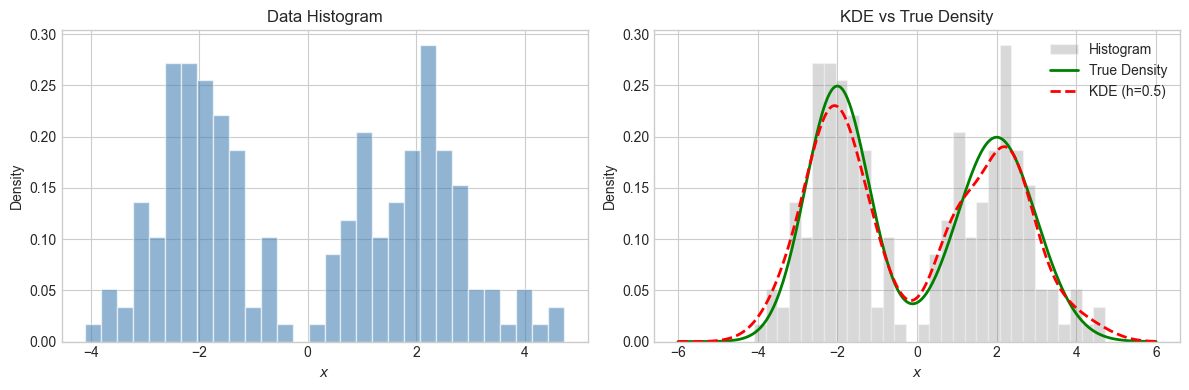

In [3]:
# Generate bimodal data (mixture of two Gaussians)
np.random.seed(42)
n_samples = 200
data = np.concatenate([
    np.random.normal(-2, 0.8, n_samples // 2),
    np.random.normal(2, 1.0, n_samples // 2)
])

# True density (mixture of Gaussians)
x_grid = np.linspace(-6, 6, 500)
true_density = 0.5 * stats.norm.pdf(x_grid, -2, 0.8) + 0.5 * stats.norm.pdf(x_grid, 2, 1.0)

# Apply our KDE
bandwidth = 0.5
kde_estimate = kde_scratch(x_grid, data, bandwidth)

# Visualize
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Left: Data histogram
axes[0].hist(data, bins=30, density=True, alpha=0.6, color='steelblue', edgecolor='white')
axes[0].set_xlabel('$x$')
axes[0].set_ylabel('Density')
axes[0].set_title('Data Histogram')

# Right: KDE estimate vs true density
axes[1].hist(data, bins=30, density=True, alpha=0.3, color='gray', edgecolor='white', label='Histogram')
axes[1].plot(x_grid, true_density, 'g-', lw=2, label='True Density')
axes[1].plot(x_grid, kde_estimate, 'r--', lw=2, label=f'KDE (h={bandwidth})')
axes[1].set_xlabel('$x$')
axes[1].set_ylabel('Density')
axes[1].set_title('KDE vs True Density')
axes[1].legend()

plt.tight_layout()
plt.show()

## 3. Bandwidth Selection: Bias-Variance Trade-off

The bandwidth $h$ controls the smoothness of the estimate:

- **Small $h$**: Low bias, high variance → spiky, overfits to individual points
- **Large $h$**: High bias, low variance → over-smoothed, loses detail

This is analogous to the choice of $k$ in KNN.

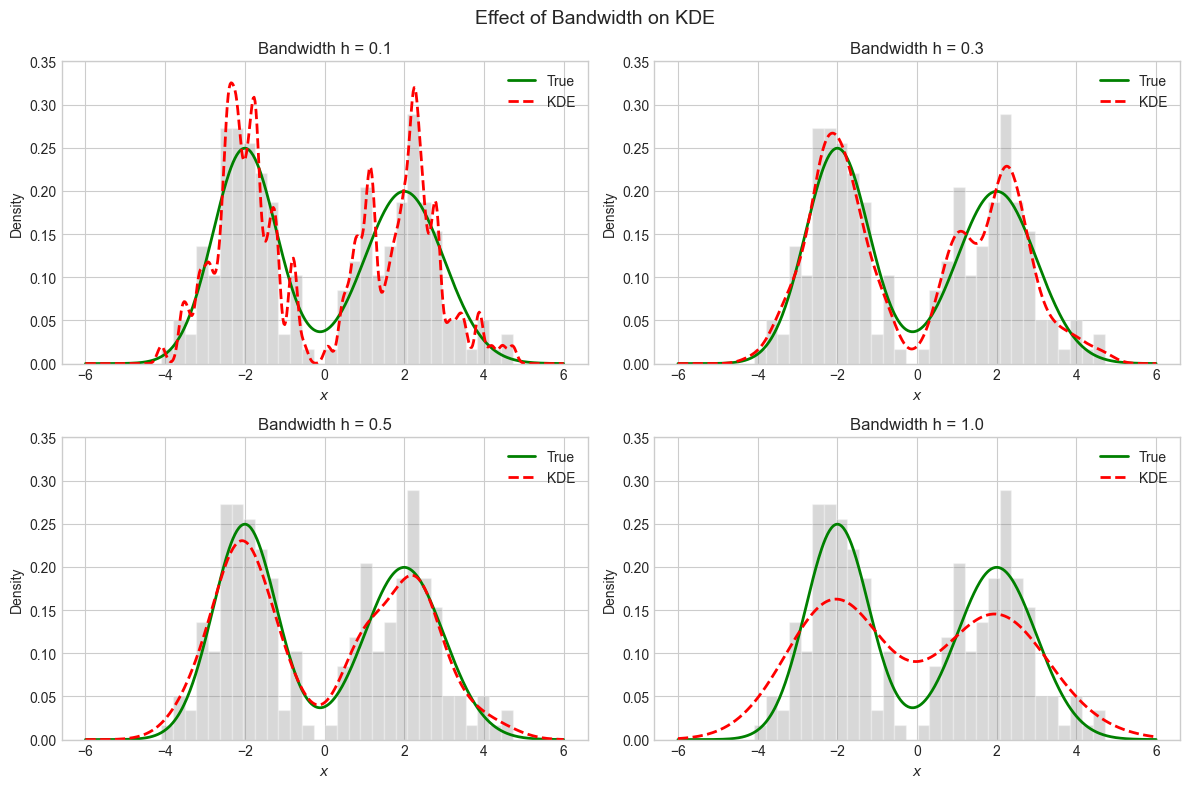

h=0.1: Undersmoothed (overfitting)
h=0.3-0.5: Good balance
h=1.0: Oversmoothed (loses bimodality)


In [4]:
# Demonstrate effect of bandwidth
bandwidths = [0.1, 0.3, 0.5, 1.0]

fig, axes = plt.subplots(2, 2, figsize=(12, 8))
axes = axes.flatten()

for ax, h in zip(axes, bandwidths):
    kde_est = kde_scratch(x_grid, data, h)
    
    ax.hist(data, bins=30, density=True, alpha=0.3, color='gray', edgecolor='white')
    ax.plot(x_grid, true_density, 'g-', lw=2, label='True')
    ax.plot(x_grid, kde_est, 'r--', lw=2, label=f'KDE')
    ax.set_xlabel('$x$')
    ax.set_ylabel('Density')
    ax.set_title(f'Bandwidth h = {h}')
    ax.legend()
    ax.set_ylim(0, 0.35)

plt.suptitle('Effect of Bandwidth on KDE', fontsize=14)
plt.tight_layout()
plt.show()

print("h=0.1: Undersmoothed (overfitting)")
print("h=0.3-0.5: Good balance")
print("h=1.0: Oversmoothed (loses bimodality)")

## 4. How KDE Builds Up

Visualize how individual kernels combine to form the density estimate.

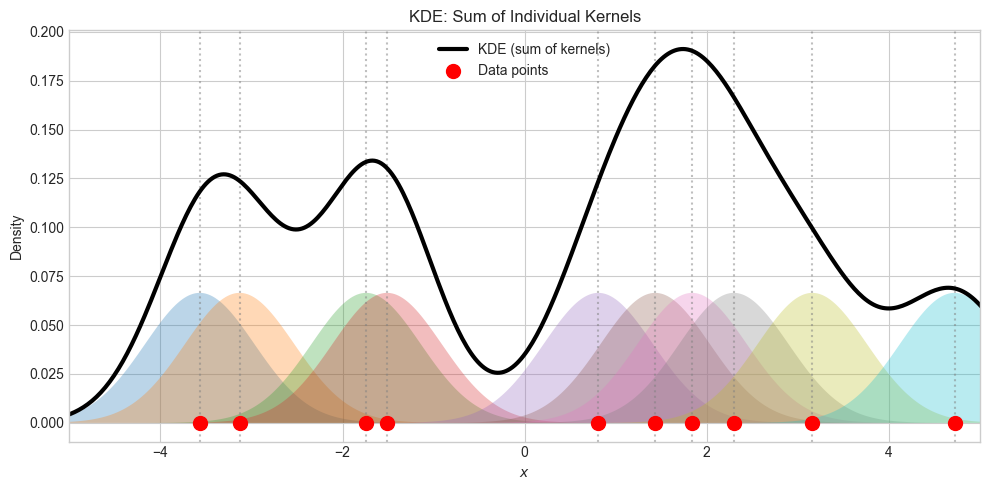

In [5]:
# Use a small subset to visualize individual kernels
np.random.seed(123)
small_data = np.random.choice(data, 10, replace=False)
small_data.sort()

h = 0.6
n = len(small_data)

fig, ax = plt.subplots(figsize=(10, 5))

# Plot individual kernels (scaled)
for xi in small_data:
    kernel_contrib = gaussian_kernel((x_grid - xi) / h) / (n * h)
    ax.fill_between(x_grid, kernel_contrib, alpha=0.3)
    ax.axvline(xi, color='gray', linestyle=':', alpha=0.5)

# Plot the sum (KDE)
kde_sum = kde_scratch(x_grid, small_data, h)
ax.plot(x_grid, kde_sum, 'k-', lw=3, label='KDE (sum of kernels)')

# Mark data points
ax.scatter(small_data, np.zeros_like(small_data), c='red', s=100, zorder=5, label='Data points')

ax.set_xlabel('$x$')
ax.set_ylabel('Density')
ax.set_title('KDE: Sum of Individual Kernels')
ax.legend()
ax.set_xlim(-5, 5)

plt.tight_layout()
plt.show()

## 5. 2D Kernel Density Estimation

KDE extends naturally to multiple dimensions. In 2D:

$$\hat{p}(x) = \frac{1}{n} \sum_{i=1}^n K_H(x - x_i)$$

where $K_H$ is a multivariate kernel with bandwidth matrix $H$.

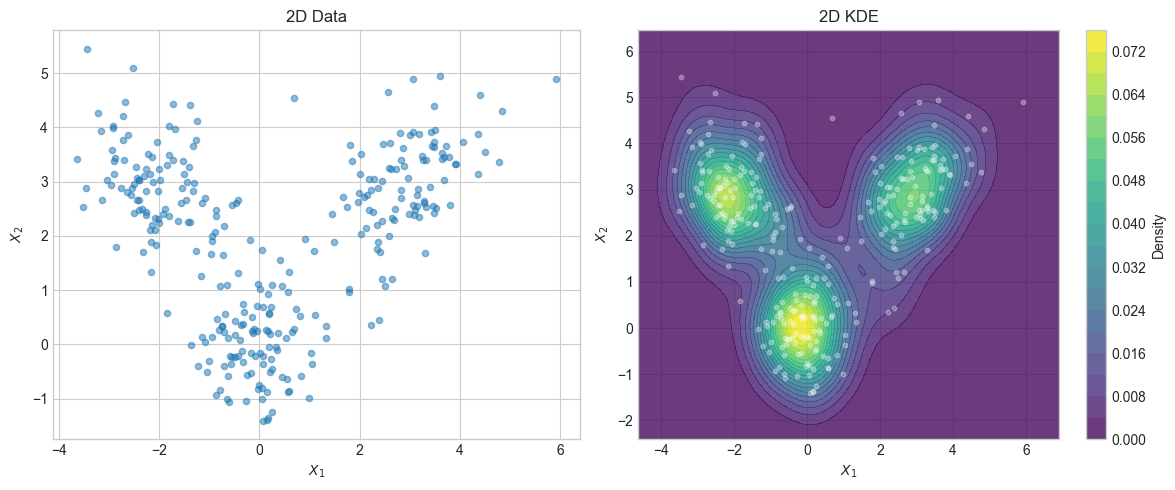

In [6]:
# Generate 2D data (mixture of 3 Gaussians)
np.random.seed(42)
n_per_cluster = 100

cluster1 = np.random.multivariate_normal([0, 0], [[0.5, 0], [0, 0.5]], n_per_cluster)
cluster2 = np.random.multivariate_normal([3, 3], [[0.8, 0.3], [0.3, 0.8]], n_per_cluster)
cluster3 = np.random.multivariate_normal([-2, 3], [[0.6, -0.2], [-0.2, 0.6]], n_per_cluster)

data_2d = np.vstack([cluster1, cluster2, cluster3])

# Fit 2D KDE using sklearn
kde_2d = KernelDensity(kernel='gaussian', bandwidth=0.5)
kde_2d.fit(data_2d)

# Create grid for evaluation
x_min, x_max = data_2d[:, 0].min() - 1, data_2d[:, 0].max() + 1
y_min, y_max = data_2d[:, 1].min() - 1, data_2d[:, 1].max() + 1
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100), np.linspace(y_min, y_max, 100))
grid_points = np.c_[xx.ravel(), yy.ravel()]

# Evaluate density
log_dens = kde_2d.score_samples(grid_points)
zz = np.exp(log_dens).reshape(xx.shape)

# Visualize
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Left: scatter plot
axes[0].scatter(data_2d[:, 0], data_2d[:, 1], alpha=0.5, s=20)
axes[0].set_xlabel('$X_1$')
axes[0].set_ylabel('$X_2$')
axes[0].set_title('2D Data')

# Right: KDE contour
contour = axes[1].contourf(xx, yy, zz, levels=20, cmap='viridis', alpha=0.8)
axes[1].scatter(data_2d[:, 0], data_2d[:, 1], c='white', alpha=0.3, s=10)
axes[1].set_xlabel('$X_1$')
axes[1].set_ylabel('$X_2$')
axes[1].set_title('2D KDE')
plt.colorbar(contour, ax=axes[1], label='Density')

plt.tight_layout()
plt.show()